# Imports

In [86]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import cv2
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [87]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [88]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

In [89]:
# What model to download.
MODEL_NAME = 'Number_Plate_detection_Model/'
#MODEL_NAME = 'Number_Plate_detection_Model1/'
MODEL_FILE = MODEL_NAME + '.tar.gz'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'object-detection.pbtxt')

## Load a (frozen) Tensorflow model into memory.

In [90]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [91]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [92]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [185]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_numberplate'
#PATH_TO_TEST_IMAGES_DIR = '/home2/aparaye/text_detection/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'test{}.jpg'.format(i)) for i in range(1, 5) ]

# Size, in inches, of the output images.abs



IMAGE_SIZE = (12, 8)

In [94]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

(480, 640, 3)
hello 
(480, 640, 3)
hello 
(480, 640, 3)
hello 
(480, 640, 3)
hello 


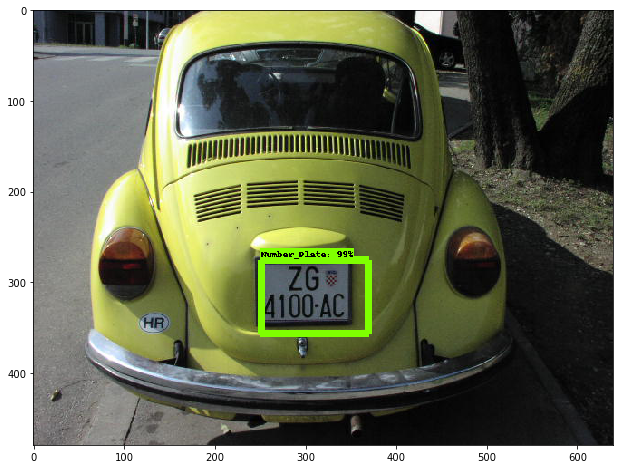

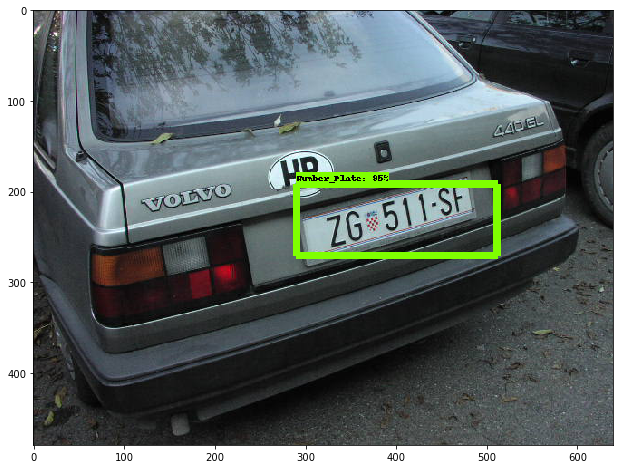

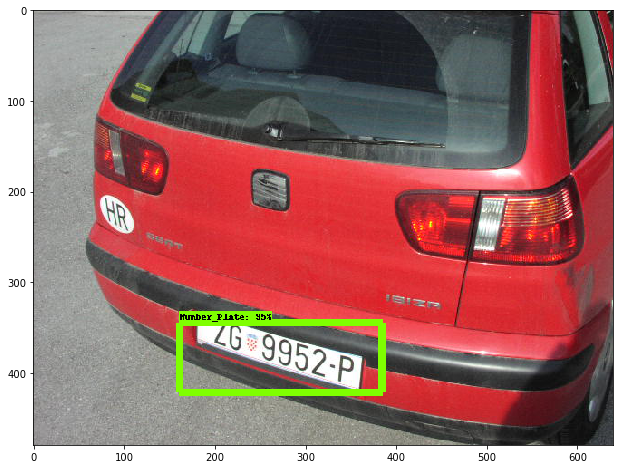

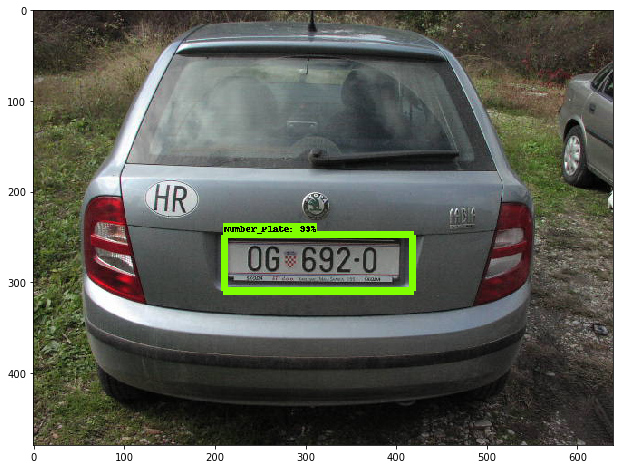

In [194]:
import pytesseract
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  

In [195]:
def image_to_text(box_score,image_np):
    b=(int(box_score[1]*640),int(box_score[0]*480),int(box_score[3]*640),int(box_score[2]*480))
    image_np=image_np[0:100,0:100]
    print("hello",pytesseract.image_to_string(image))

  

This is the first line of
this text example.

This is the second line
of the same text.


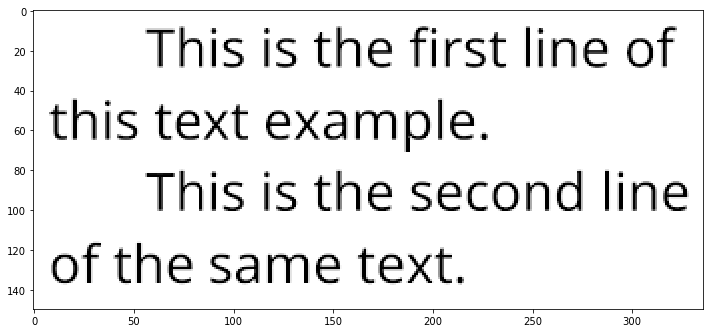

In [177]:
import cv2
import pytesseract
 

image = cv2.imread("/home2/aparaye/text_detection/t1.png")
print(pytesseract.image_to_string(image))
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)
#crop=image[182:267,267:476]
#print(crop.size)


In [ ]:
 a=(output_dict['detection_boxes'][0])  
  
  b=(int(a[0]*640),int(a[1]*480),int(a[2]*640),int(a[3]*480))  
  #image = cv2.imread(image_path)
  #crop=image[b[1]:b[0],b[3]:b[2]]
  #print(crop.shape)
  #crop=image[b[0]:b[1],b[2]:b[3]]
  #print(b)
  font = cv2.FONT_HERSHEY_SIMPLEX
  cv2.putText(image_np,pytesseract.image_to_string(image_np), (10,200), font, 8, 255)
  print(pytesseract.image_to_string(image_np))   
  cv2.imshow('result',image_np)
  cv2.waitKey(0) 

In [ ]:
try:  
    from PIL import Image
except ImportError:  
    import Image
import pytesseract

def ocr_core(filename):  
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text

print(ocr_core('images/ocr_example_1.png'))  

In [ ]:
print(image_np.shape)  
  box_score=(output_dict['detection_boxes'][0])   
  image_to_text(box_score,image_np)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)